In [3]:
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [51]:
DATA_DIR = "/mnt/efs/lit-pcba/FEN1/"
SUMMARY_FILE = "vina_medium_ex8_summary.csv"

In [9]:
!ls -al $DATA_DIR

total 20896
drwxr-xr-x 4 root   root       6144 May 24 16:28 .
drwxr-xr-x 3 root   root       6144 May 19 19:37 ..
-rw-r----- 1 root   root       3560 May 20 22:39 5fv7_ligand.mol2
-rw-r----- 1 root   root     546610 May 20 22:39 5fv7_protein.mol2
-rw-r--r-- 1 root   root      20868 May 20 22:39 actives.smi
-rw-r--r-- 1 root   root      78071 May 22 18:56 autodock_medium_cuda_old_summary.csv
-rw-r--r-- 1 root   root      77299 May 24 14:21 autodock_medium_summary.csv
-rw-r--r-- 1 root   root      77300 May 24 16:27 autodock_small_summary.csv
-rw-r--r-- 1 root   root      41189 May 20 22:39 inactives_700.smi
-rw-r--r-- 1 root   root   19553251 May 20 22:39 inactives.smi
drwxr-xr-x 2 root   root     145408 May 20 22:40 ligands
-rw-r--r-- 1 root   root        217 May 20 22:40 params.json
-rw-r--r-- 1 root   root        195 May 23 19:55 qvina02_config.txt
-rw-r--r-- 1 root   root      73286 May 24 06:23 qvina02_large_ex16_summary.csv
-rw-r--r-- 1 root   root      73286 May 23 17:06 qvina02

## Load actives and inactives

In [6]:
actives = pd.read_csv(f"{DATA_DIR}/actives.smi", sep=" ", names=["Smiles", "Ligand"])
actives["Active"] = 1
inactives = pd.read_csv(f"{DATA_DIR}/inactives_700.smi", sep=" ", names=["Smiles", "Ligand"])
inactives["Active"] = 0
ligands_df = pd.concat([actives, inactives]).reset_index(drop=True)

In [7]:
ligands_df.head()

,Smiles,Ligand,Active
0,Cc1ccc2C3C=CCC3C(Nc2c1C)C(=O)[O-],844096,1
1,Oc1ccc(Nc2nc(N3CCCC3)c4ccccc4n2)cc1,852615,1
2,C[NH+](C)[C@H]1[C@@H]2CC3C(=C([O-])[C@]2(O)C(=...,855713,1
3,ON1C(=O)C(=O)N(O)c2ccccc12,857795,1
4,ON1C(=O)c2cccc3c(ccc(C1=O)c23)C(=O)N4CCCCC4,857966,1


## Load summary df

In [52]:
summary_df = pd.read_csv(f"{DATA_DIR}/{SUMMARY_FILE}", sep=";", header=0, names=["Ligand Taut", "Score"])
summary_df["Ligand"] = summary_df["Ligand Taut"].apply(lambda row: int(row.split("_")[0]))
summary_df["Neg Score"] = summary_df["Score"] * -1
summary_df = summary_df.groupby("Ligand", as_index=False)["Neg Score"].max()

In [53]:
summary_df = summary_df.merge(ligands_df[["Ligand", "Active"]], on="Ligand")

In [54]:
summary_df["Neg Score"].min(), summary_df["Neg Score"].max()

(3.8, 8.3)

## Calculate ROC-AUC

In [55]:
def calculate_roc_curve(y_true, y_score):
    roc_auc = roc_auc_score(y_true=y_true, y_score=y_score)
    print(f"ROC-AUC Score: {round(roc_auc, 3)} for file: {SUMMARY_FILE}")
    
    fpr, tpr, thresholds = roc_curve(y_true=y_true, y_score=y_score)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

ROC-AUC Score: 0.611 for file: vina_medium_ex8_summary.csv


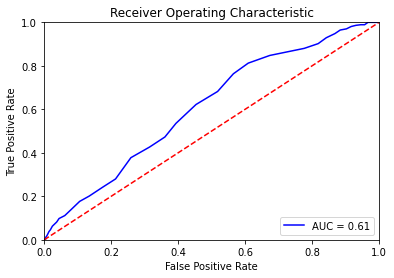

In [56]:
calculate_roc_curve(y_true=summary_df["Active"], y_score=summary_df["Neg Score"])